In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import GridSearchCV

In [2]:
train_dir = 'Dataset/train'
validation_dir = 'Dataset/val'
test_dir = 'Dataset/test'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
train_dataset = image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 38391 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 8226 files belonging to 2 classes.


In [6]:
test_dataset = image_dataset_from_directory(test_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 8227 files belonging to 2 classes.


In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 258
Number of test batches: 258


# Autotuning for better performance

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation layer

In [9]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

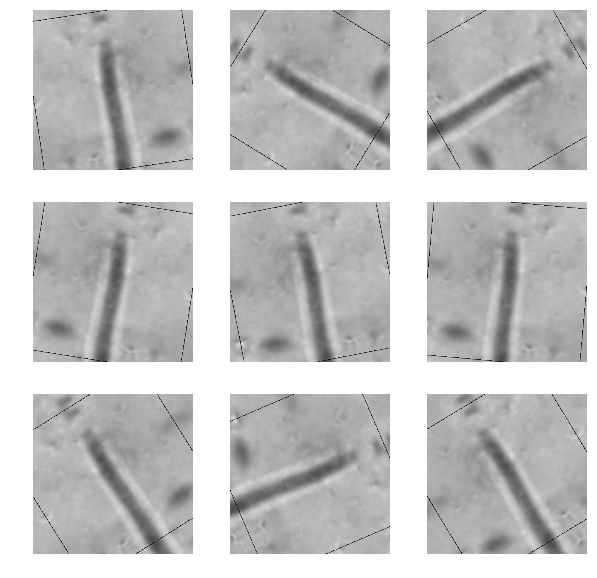

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
first_image = image[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Preprocessing of images [0,255] -> [-1, 1]

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Model without weights

In [12]:
# Create the base model from the pre-trained model  MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Adding last layer (using logit)

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# Final model

In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Optimizer and other training hyperparameters

In [17]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
len(model.trainable_variables)

158

In [19]:
initial_epochs = 40
loss0, accuracy0 = model.evaluate(validation_dataset)

258/258 [==============================] - 68s 262ms/step - loss: 0.6931 - accuracy: 0.4573


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.46


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/40
1200/1200 [==============================] - 1764s 1s/step - loss: 0.3168 - accuracy: 0.8637 - val_loss: 0.9963 - val_accuracy: 0.4573
Epoch 2/40
1200/1200 [==============================] - 1731s 1s/step - loss: 0.2442 - accuracy: 0.9015 - val_loss: 2.0366 - val_accuracy: 0.4573
Epoch 3/40
1200/1200 [==============================] - 1682s 1s/step - loss: 0.2190 - accuracy: 0.9134 - val_loss: 3.6947 - val_accuracy: 0.4573
Epoch 4/40
1200/1200 [==============================] - 1702s 1s/step - loss: 0.2060 - accuracy: 0.9207 - val_loss: 0.7481 - val_accuracy: 0.7967
Epoch 5/40
1200/1200 [==============================] - 1682s 1s/step - loss: 0.1892 - accuracy: 0.9286 - val_loss: 3.7748 - val_accuracy: 0.5462
Epoch 6/40
1200/1200 [==============================] - 1702s 1s/step - loss: 0.1804 - accuracy: 0.9315 - val_loss: 5.9696 - val_accuracy: 0.5427
Epoch 7/40
1200/1200 [==============================] - 1677s 1s/step - loss: 0.1668 - accuracy: 0.9367 - val_loss: 4.8999 -

KeyboardInterrupt: 

In [22]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'history' is not defined

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

258/258 [==============================] - 41s 160ms/step - loss: 0.5640 - accuracy: 0.8606
Test accuracy : 0.8605640530586243
